In [1]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [3]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [4]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

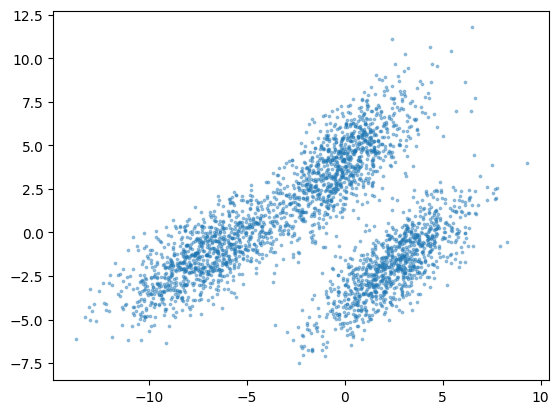

In [5]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [6]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

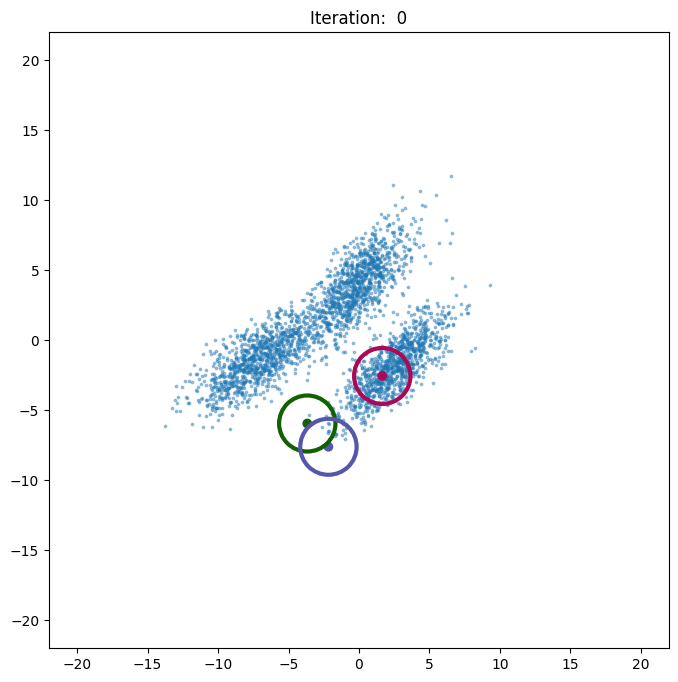

Iteration: 1, log-likelihood: -15524.9019


<Figure size 640x480 with 0 Axes>

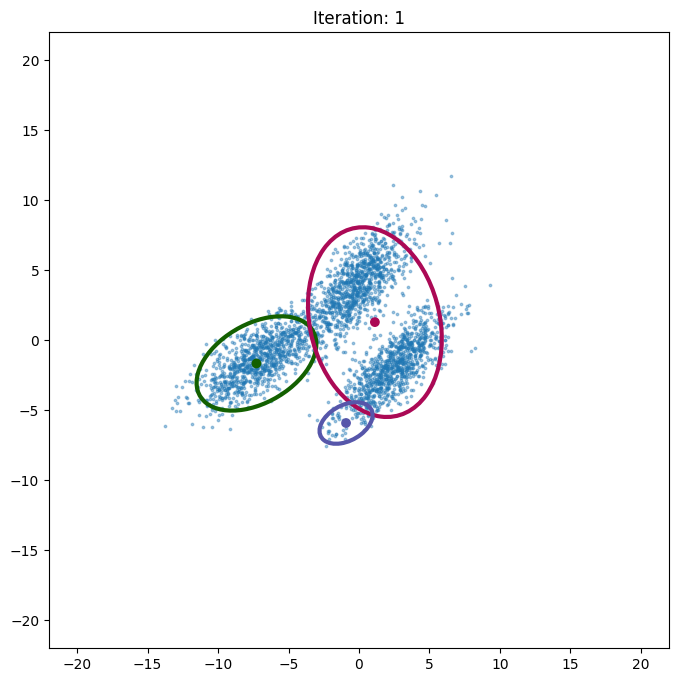

Iteration: 2, log-likelihood: -15396.3066


<Figure size 640x480 with 0 Axes>

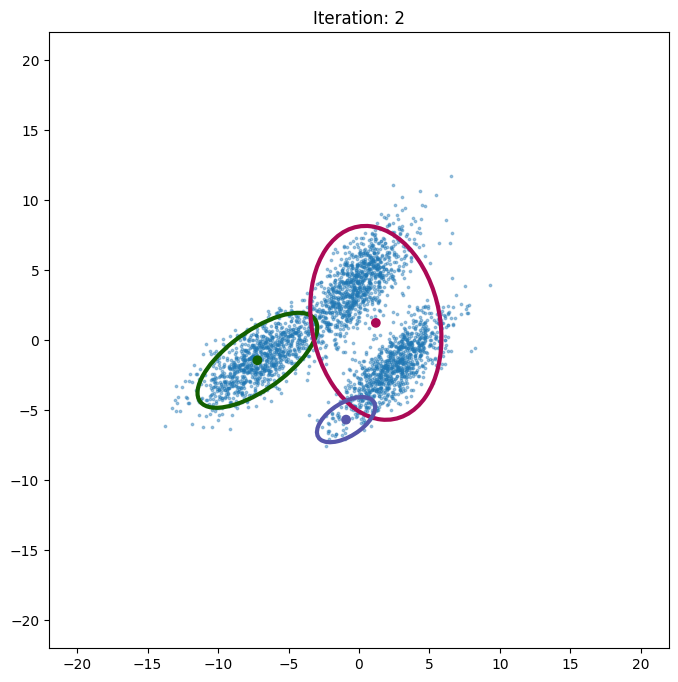

Iteration: 3, log-likelihood: -15370.7213


<Figure size 640x480 with 0 Axes>

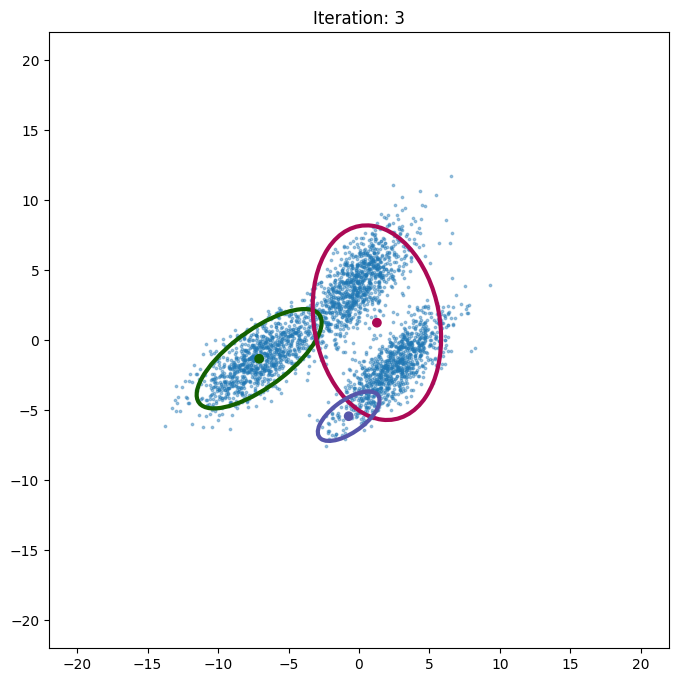

Iteration: 4, log-likelihood: -15347.4951


<Figure size 640x480 with 0 Axes>

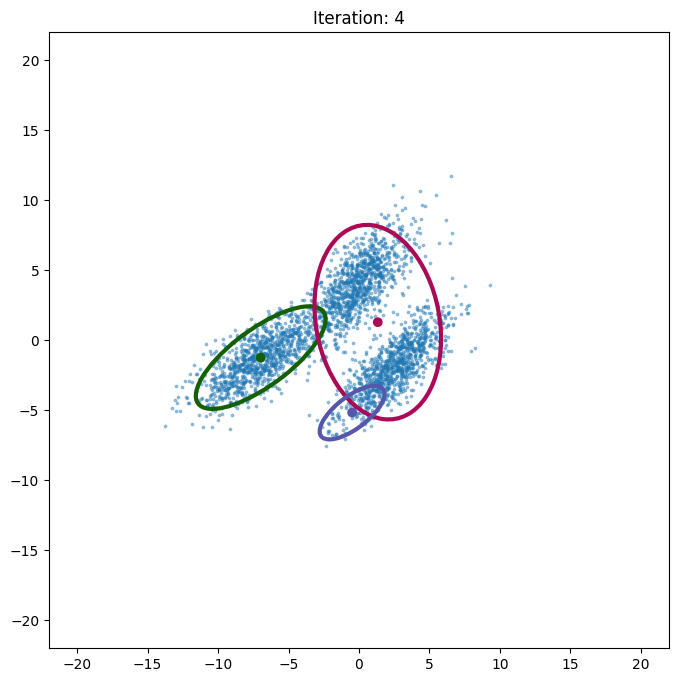

Iteration: 5, log-likelihood: -15321.9326


<Figure size 640x480 with 0 Axes>

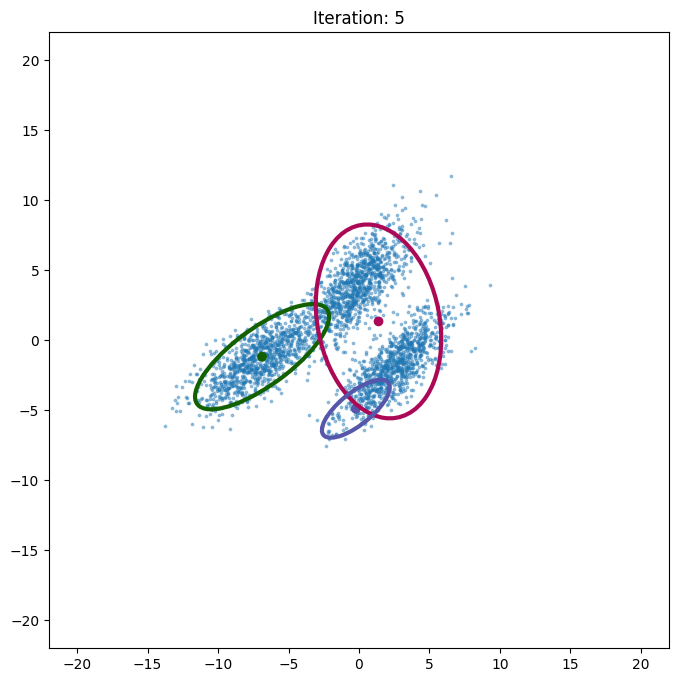

Iteration: 6, log-likelihood: -15292.1224


<Figure size 640x480 with 0 Axes>

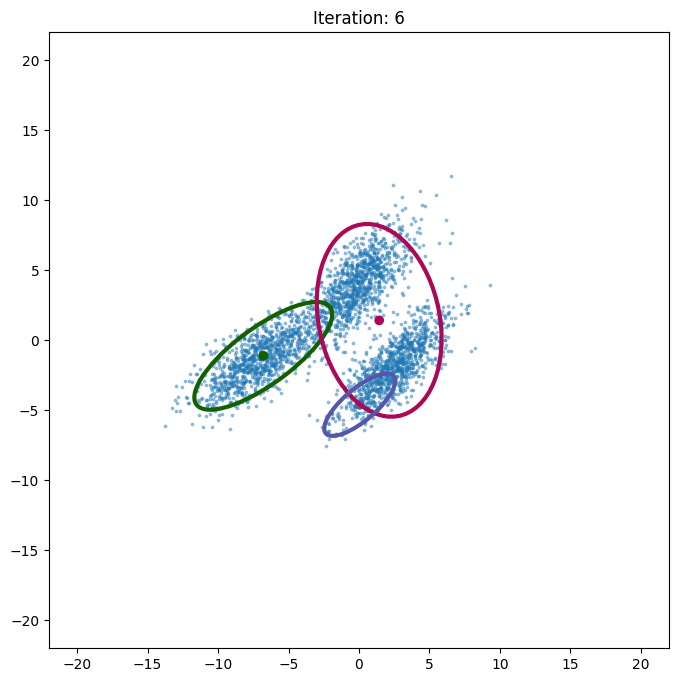

Iteration: 7, log-likelihood: -15256.7624


<Figure size 640x480 with 0 Axes>

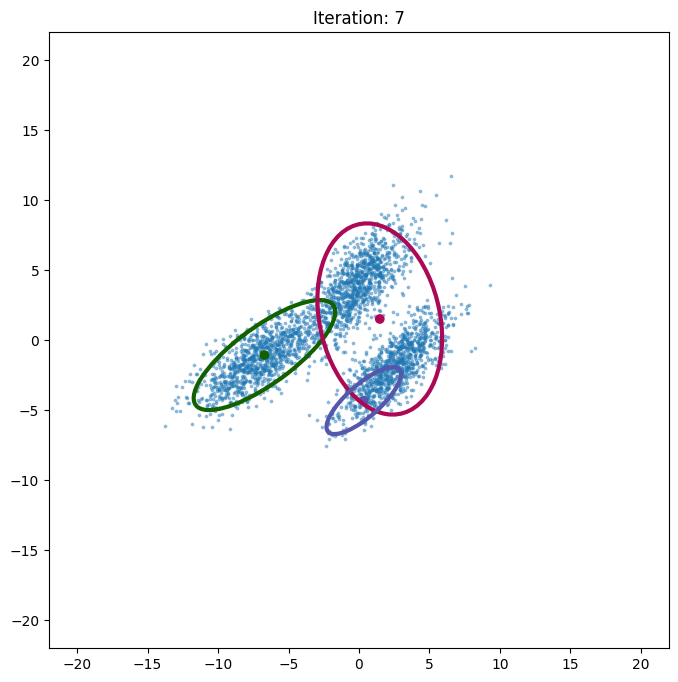

Iteration: 8, log-likelihood: -15214.9181


<Figure size 640x480 with 0 Axes>

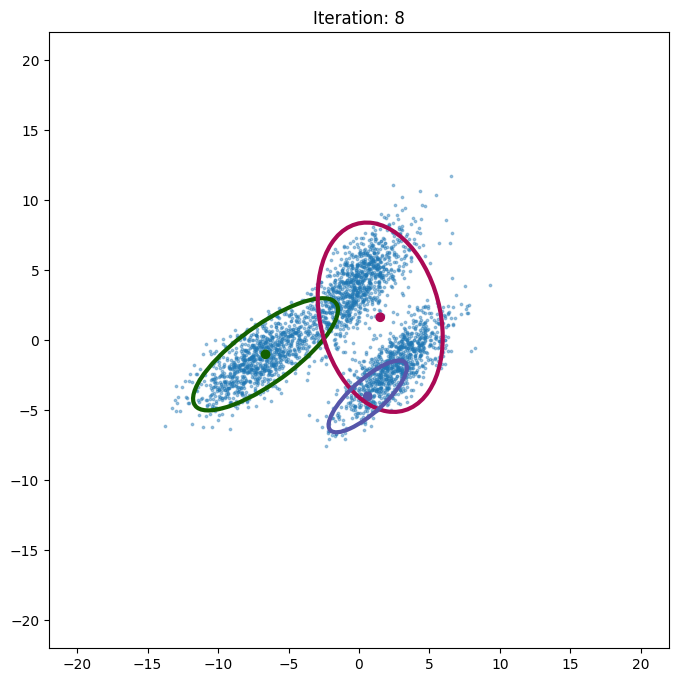

Iteration: 9, log-likelihood: -15166.5032


<Figure size 640x480 with 0 Axes>

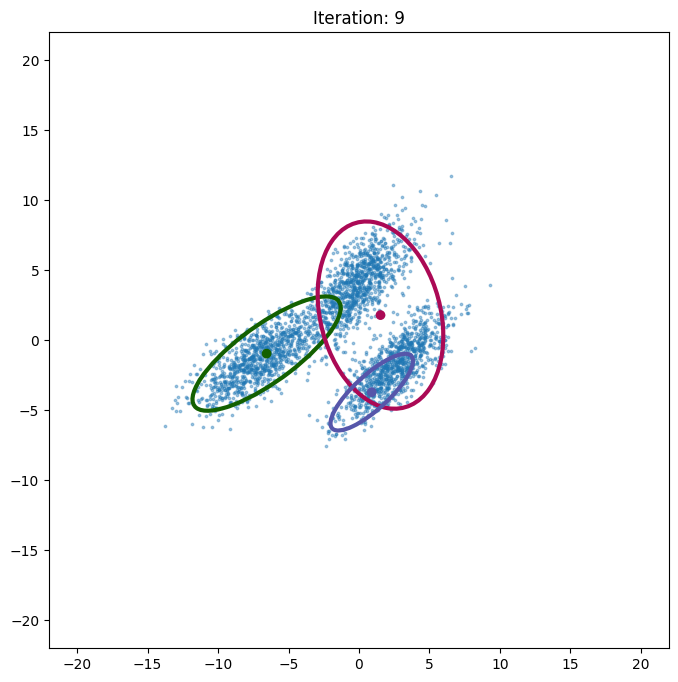

Iteration: 10, log-likelihood: -15112.8114


<Figure size 640x480 with 0 Axes>

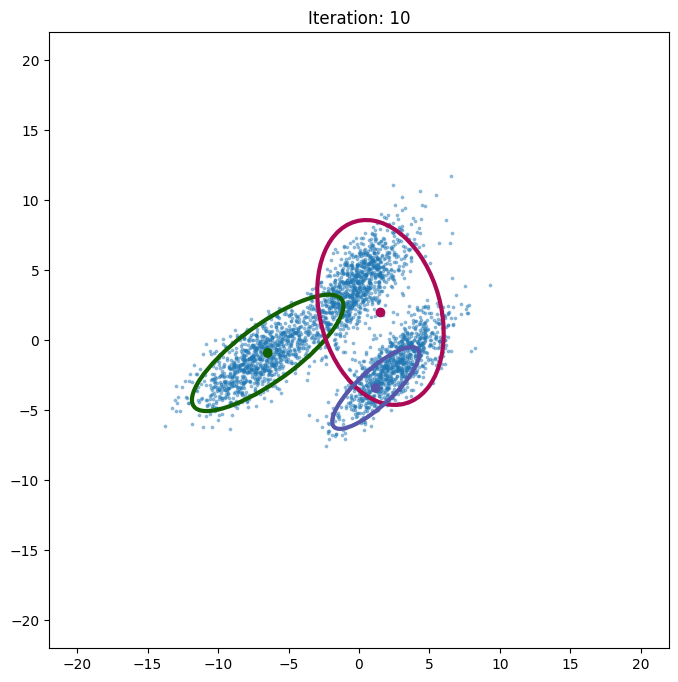

Iteration: 11, log-likelihood: -15056.3397


<Figure size 640x480 with 0 Axes>

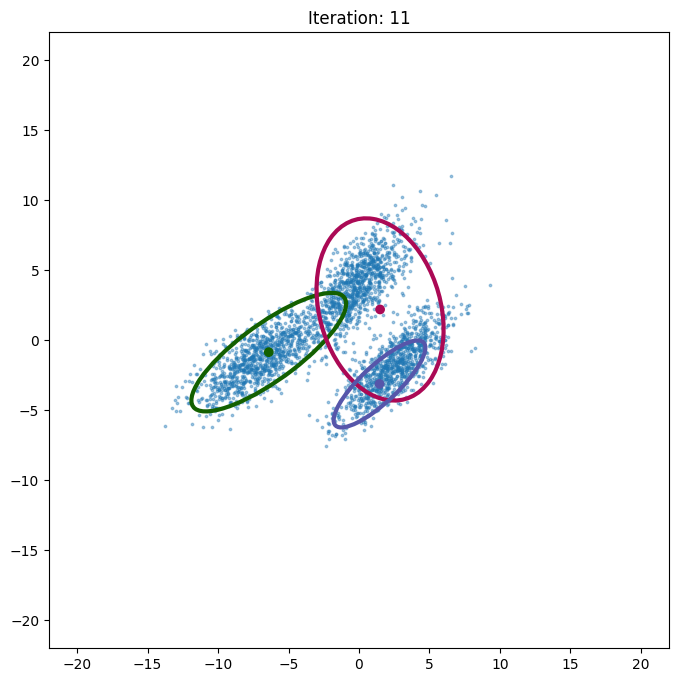

Iteration: 12, log-likelihood: -15000.2289


<Figure size 640x480 with 0 Axes>

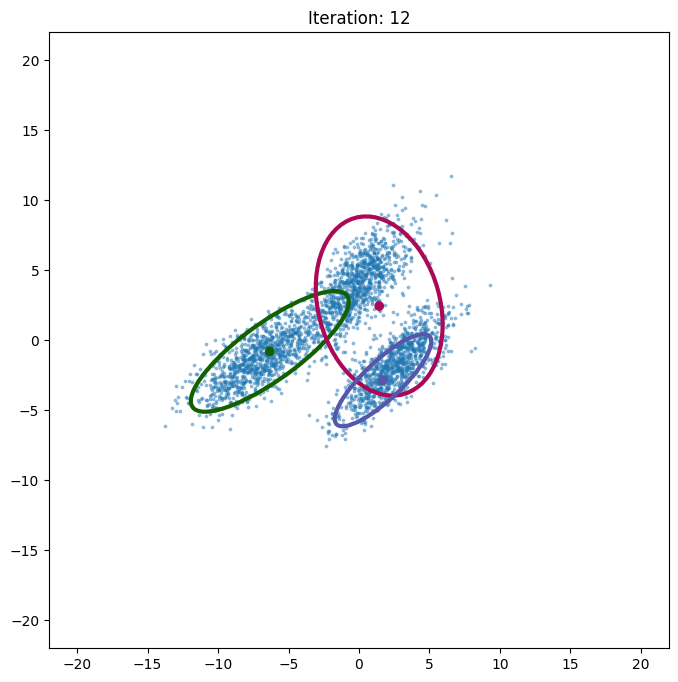

Iteration: 13, log-likelihood: -14947.1797


<Figure size 640x480 with 0 Axes>

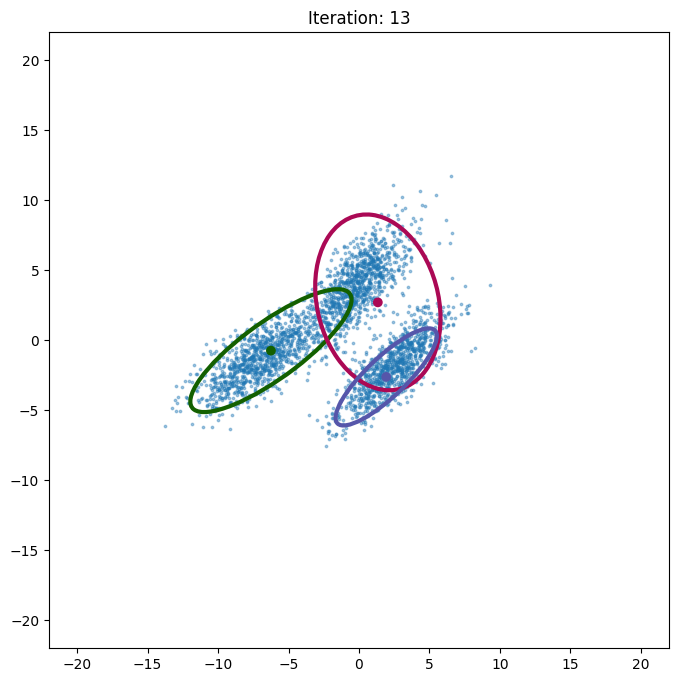

Iteration: 14, log-likelihood: -14898.4191


<Figure size 640x480 with 0 Axes>

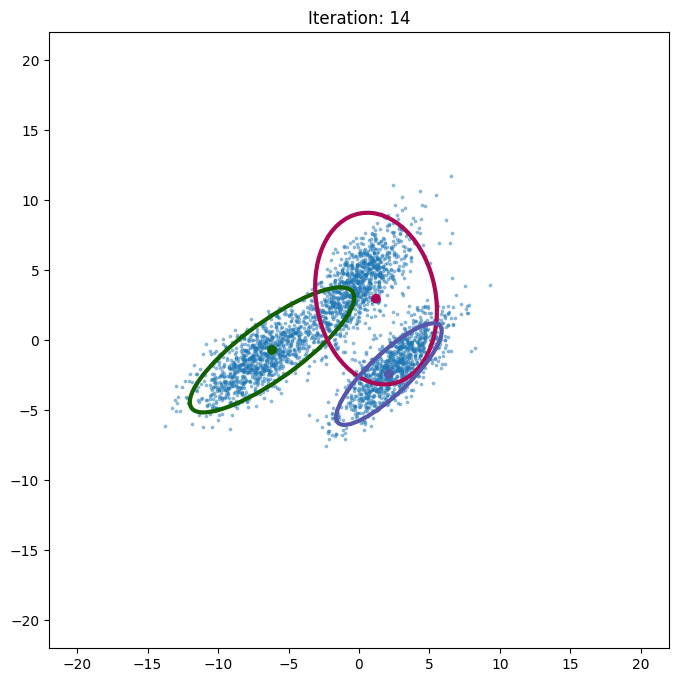

Iteration: 15, log-likelihood: -14853.1794


<Figure size 640x480 with 0 Axes>

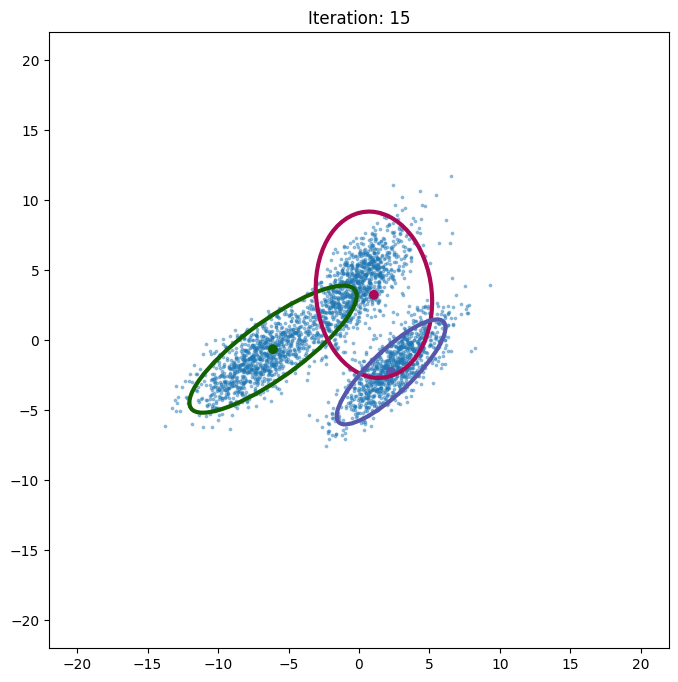

Iteration: 16, log-likelihood: -14806.0531


<Figure size 640x480 with 0 Axes>

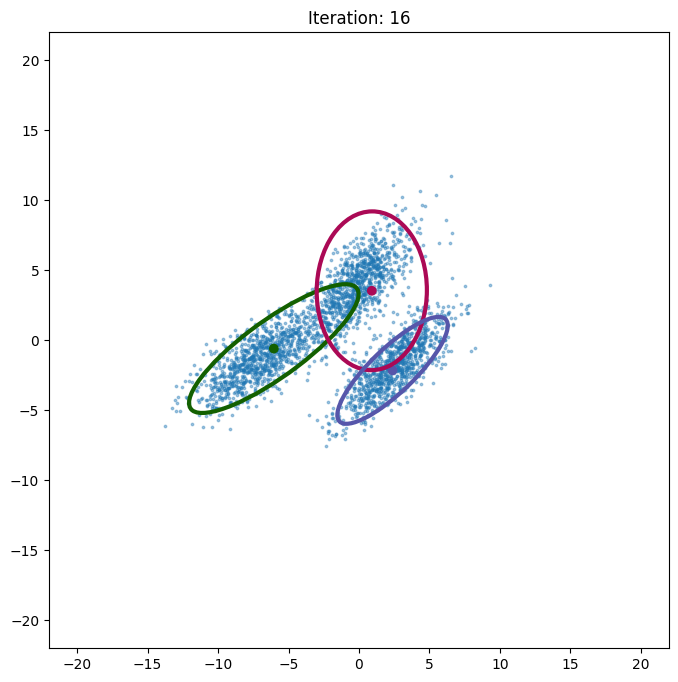

Iteration: 17, log-likelihood: -14743.8654


<Figure size 640x480 with 0 Axes>

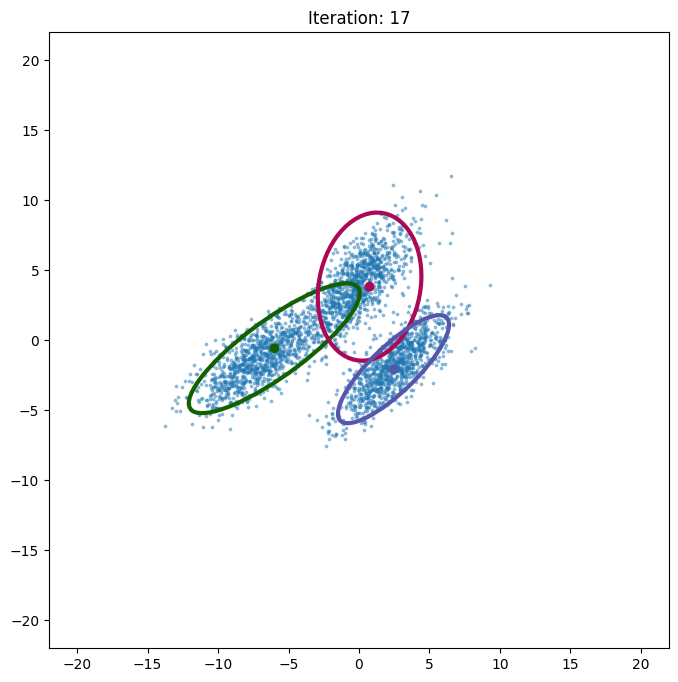

Iteration: 18, log-likelihood: -14657.3189


<Figure size 640x480 with 0 Axes>

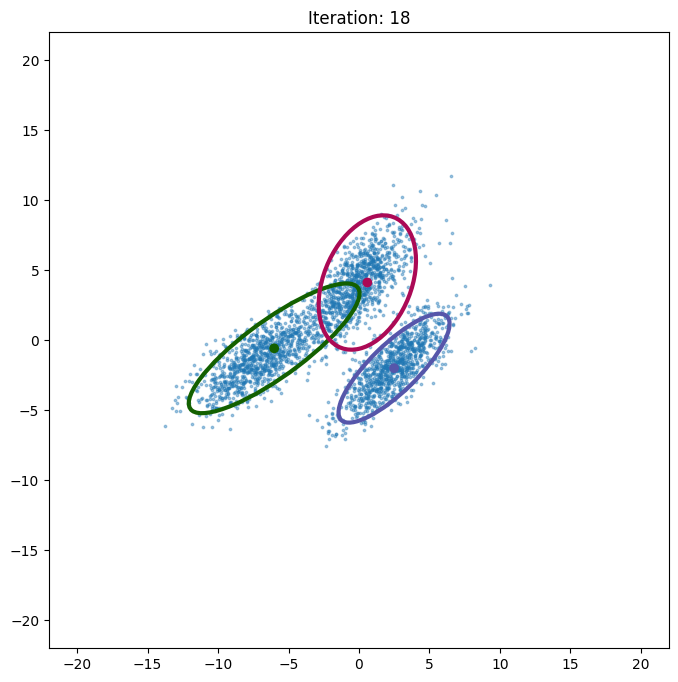

Iteration: 19, log-likelihood: -14570.7712


<Figure size 640x480 with 0 Axes>

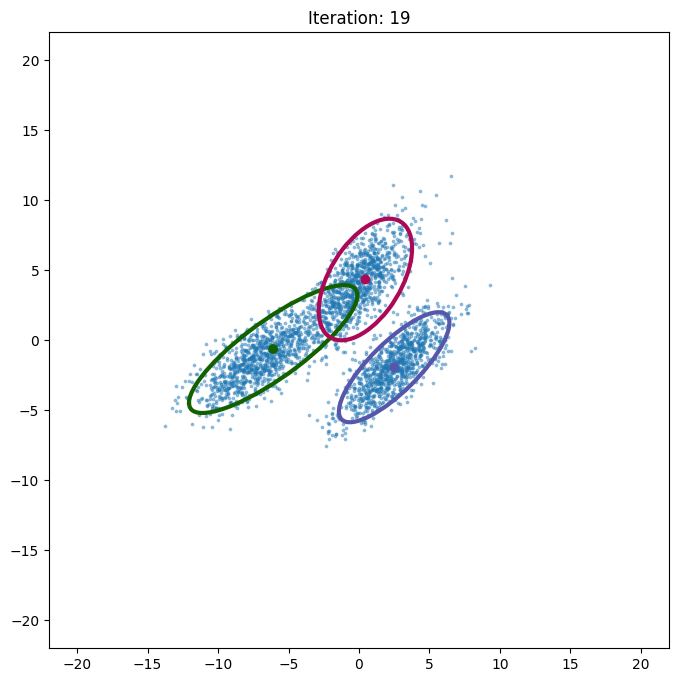

Iteration: 20, log-likelihood: -14532.0858


<Figure size 640x480 with 0 Axes>

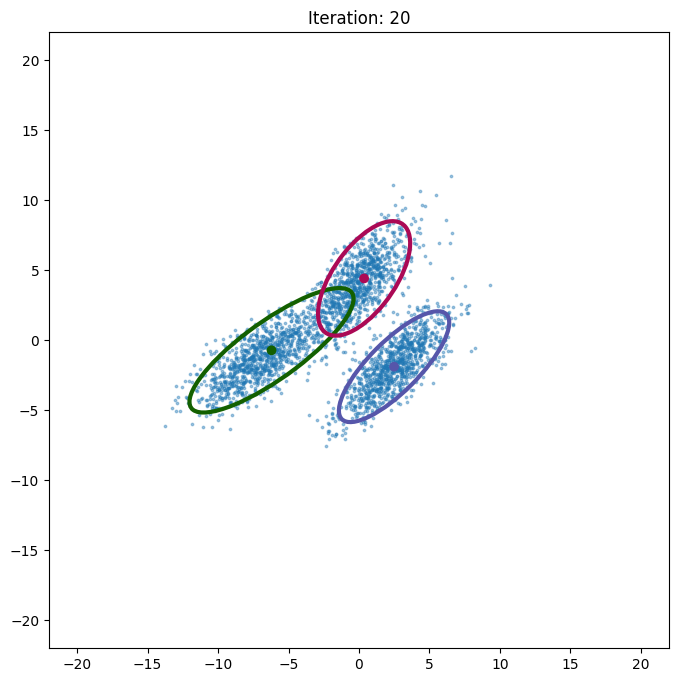

<Figure size 640x480 with 0 Axes>

In [7]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))